In [1]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"   # disable torch.compile / torch._dynamo

import torch
torch._dynamo.disable()                  # extra safety
print("torch version:", torch.__version__)
print("torch._dynamo disabled")

torch version: 2.9.0+cu126
torch._dynamo disabled


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
CUDA version: 12.6
GPU: Tesla T4


In [4]:
!pip install torch torchvision torchaudio

In [5]:
!pip -q install pillow numpy pandas einops
!pip -q install torch-fidelity lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00


In [6]:
!nvidia-smi

Sat Dec 13 23:46:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import os

BASE = "/content/artifacts"
CKPT_DIR = f"{BASE}/checkpoints"
SAMPLES_DIR = f"{BASE}/samples"
METRICS_DIR = f"{BASE}/metrics"
REAL_DIR = f"{BASE}/real_eval"

for p in [BASE, CKPT_DIR, SAMPLES_DIR, METRICS_DIR, REAL_DIR]:
    os.makedirs(p, exist_ok=True)

print("Artifacts root:", BASE)

Artifacts root: /content/artifacts


In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celebahq-resized-256x256' dataset.
Path to dataset files: /kaggle/input/celebahq-resized-256x256


In [21]:
import os

print("Top-level files:", os.listdir(path)[:20])

Top-level files: ['celeba_hq_256']


In [22]:
import os, glob

path = "/kaggle/input/celebahq-resized-256x256"  # from kagglehub output
print("Top-level:", os.listdir(path))

sub = os.path.join(path, "celeba_hq_256")
print("Inside celeba_hq_256:", os.listdir(sub)[:20])

# Count images in both levels
def count_imgs(folder):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.webp","*.WEBP"]
    return sum(len(glob.glob(os.path.join(folder, e))) for e in exts)

print("Images in path:", count_imgs(path))
print("Images in subfolder:", count_imgs(sub))

# If images are directly inside subfolder, set DATASET_DIR to subfolder
DATASET_DIR = sub
print("✅ Using DATASET_DIR:", DATASET_DIR)
print("✅ Image count:", count_imgs(DATASET_DIR))

Top-level: ['celeba_hq_256']
Inside celeba_hq_256: ['08450.jpg', '19812.jpg', '22735.jpg', '16916.jpg', '05938.jpg', '06122.jpg', '08536.jpg', '22706.jpg', '20513.jpg', '12666.jpg', '04168.jpg', '13288.jpg', '02371.jpg', '20088.jpg', '28578.jpg', '04377.jpg', '22288.jpg', '09924.jpg', '24819.jpg', '00767.jpg']
Images in path: 0
Images in subfolder: 30000
✅ Using DATASET_DIR: /kaggle/input/celebahq-resized-256x256/celeba_hq_256
✅ Image count: 30000


In [24]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob, os

class ImageDataset(Dataset):
    def __init__(self, folder):
        exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.webp","*.WEBP"]
        self.paths = []
        for e in exts:
            self.paths += glob.glob(os.path.join(folder, e))
        self.paths = sorted(self.paths)

        assert len(self.paths) > 0, f"No images found in {folder}. Check DATASET_DIR."

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

dataset = ImageDataset(DATASET_DIR)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

print("Dataset size:", len(dataset))
print("Example file:", dataset.paths[0])

Dataset size: 30000
Example file: /kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg


In [27]:
#repeat of previous cell

import os, glob

path = "/kaggle/input/celebahq-resized-256x256"  # from kagglehub output
print("Top-level:", os.listdir(path))

sub = os.path.join(path, "celeba_hq_256")
print("Inside celeba_hq_256:", os.listdir(sub)[:20])

# Count images in both levels
def count_imgs(folder):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.webp","*.WEBP"]
    return sum(len(glob.glob(os.path.join(folder, e))) for e in exts)

print("Images in path:", count_imgs(path))
print("Images in subfolder:", count_imgs(sub))

# If images are directly inside subfolder, set DATASET_DIR to subfolder
DATASET_DIR = sub
print("Using DATASET_DIR:", DATASET_DIR)
print("Image count:", count_imgs(DATASET_DIR))

Top-level: ['celeba_hq_256']
Inside celeba_hq_256: ['08450.jpg', '19812.jpg', '22735.jpg', '16916.jpg', '05938.jpg', '06122.jpg', '08536.jpg', '22706.jpg', '20513.jpg', '12666.jpg', '04168.jpg', '13288.jpg', '02371.jpg', '20088.jpg', '28578.jpg', '04377.jpg', '22288.jpg', '09924.jpg', '24819.jpg', '00767.jpg']
Images in path: 0
Images in subfolder: 30000
Using DATASET_DIR: /kaggle/input/celebahq-resized-256x256/celeba_hq_256
Image count: 30000


In [28]:
import glob, os

print("DATASET_DIR:", DATASET_DIR)
imgs = glob.glob(os.path.join(DATASET_DIR, "*.jpg")) + glob.glob(os.path.join(DATASET_DIR, "*.png"))
print("Image count:", len(imgs))
print("Example images:", imgs[:5])

DATASET_DIR: /kaggle/input/celebahq-resized-256x256/celeba_hq_256
Image count: 30000
Example images: ['/kaggle/input/celebahq-resized-256x256/celeba_hq_256/08450.jpg', '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/19812.jpg', '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/22735.jpg', '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/16916.jpg', '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/05938.jpg']


In [29]:
import numpy as np
import shutil
from torch_fidelity import calculate_metrics
import lpips
from PIL import Image

def to01(x):
    return (x.clamp(-1, 1) + 1) / 2

def save_grid(x, out_path, nrow=4, title=None):
    x = to01(x).detach().cpu()
    fig, axes = plt.subplots(nrow, nrow, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = x[i].permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis("off")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

def export_many_pngs(name, x_batch, out_dir, start_idx):
    os.makedirs(out_dir, exist_ok=True)
    xb = to01(x_batch).detach().cpu().numpy()
    for i in range(xb.shape[0]):
        img = (np.transpose(xb[i], (1,2,0)) * 255).astype("uint8")
        Image.fromarray(img).save(os.path.join(out_dir, f"{name}_{start_idx+i:05d}.png"))

def export_real_subset(real_dir, n=1000):
    shutil.rmtree(real_dir, ignore_errors=True)
    os.makedirs(real_dir, exist_ok=True)
    for i, p in enumerate(dataset.paths[:n]):
        shutil.copy(p, os.path.join(real_dir, f"real_{i:05d}.png"))
    return real_dir

def fid_kid(real_dir, fake_dir):
    m = calculate_metrics(
        input1=real_dir,
        input2=fake_dir,
        cuda=torch.cuda.is_available(),
        fid=True,
        kid=True,
        isc=False
    )
    return {
        "FID": float(m["frechet_inception_distance"]),
        "KID": float(m["kernel_inception_distance_mean"])
    }

lpips_net = lpips.LPIPS(net="alex").to(device)

@torch.no_grad()
def recon_lpips_metrics(model, loader, max_batches=20):
    model.eval()
    l1s, lps = [], []
    for i, x in enumerate(loader):
        x = x.to(device)
        x_hat = model.reconstruct(x)
        l1s.append(torch.mean(torch.abs(x_hat - x)).item())
        lps.append(lpips_net(x_hat, x).mean().item())
        if i + 1 >= max_batches:
            break
    return {"Recon_L1": float(np.mean(l1s)), "Recon_LPIPS": float(np.mean(lps))}

OUT_GAN = f"{SAMPLES_DIR}/stylegan2"
OUT_VQVAE = f"{SAMPLES_DIR}/vqvae2"
OUT_LDM = f"{SAMPLES_DIR}/ldm"

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 223MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [30]:
%cd /content
!rm -rf stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

/content
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch


In [31]:
%cd /content
!rm -rf stylegan2-pytorch
!git clone https://github.com/rosinality/stylegan2-pytorch.git
%cd stylegan2-pytorch
!pip -q install ninja

/content
Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 61.11 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/stylegan2-pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 4.8 MB/s eta 0:00:00


In [32]:
import os, glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

print("DATASET_DIR:", DATASET_DIR)
assert os.path.isdir(DATASET_DIR), f"Folder not found: {DATASET_DIR}"

class ImageDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(
            glob.glob(os.path.join(folder, "*.jpg")) +
            glob.glob(os.path.join(folder, "*.jpeg")) +
            glob.glob(os.path.join(folder, "*.png"))
        )
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),  # [-1,1]
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

dataset = ImageDataset(DATASET_DIR)
print("✅ Images found:", len(dataset))

BATCH_SIZE = 16
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

DATASET_DIR: /kaggle/input/celebahq-resized-256x256/celeba_hq_256
✅ Images found: 30000


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image

# ----- output folders -----
BASE = "/content/project_outputs"
CKPT_DIR = f"{BASE}/checkpoints"
SAMPLES_DIR = f"{BASE}/samples"
METRICS_DIR = f"{BASE}/metrics"
REAL_DIR = f"{BASE}/real_1000"
for d in [BASE, CKPT_DIR, SAMPLES_DIR, METRICS_DIR, REAL_DIR]:
    os.makedirs(d, exist_ok=True)

OUT_VQVAE = f"{SAMPLES_DIR}/vqvae"
OUT_LDM = f"{SAMPLES_DIR}/diffusion"
os.makedirs(OUT_VQVAE, exist_ok=True)
os.makedirs(OUT_LDM, exist_ok=True)

def to01(x):
    return (x.clamp(-1, 1) + 1) / 2

def save_grid(x, out_path, nrow=4, title=None):
    x = to01(x).detach().cpu()
    fig, axes = plt.subplots(nrow, nrow, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = x[i].permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis("off")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

def export_many_pngs(prefix, x_batch, out_dir, start_idx):
    os.makedirs(out_dir, exist_ok=True)
    xb = to01(x_batch).detach().cpu().numpy()
    for i in range(xb.shape[0]):
        img = (np.transpose(xb[i], (1,2,0)) * 255).astype("uint8")
        Image.fromarray(img).save(os.path.join(out_dir, f"{prefix}_{start_idx+i:05d}.png"))

# ----- VQ-VAE building blocks -----
class VectorQuantizer(nn.Module):
    def __init__(self, n_codes=1024, code_dim=256, beta=0.25):
        super().__init__()
        self.n_codes = n_codes
        self.code_dim = code_dim
        self.beta = beta
        self.codebook = nn.Embedding(n_codes, code_dim)
        self.codebook.weight.data.uniform_(-1/n_codes, 1/n_codes)

    def forward(self, z):
        z_perm = z.permute(0,2,3,1).contiguous()          # BCHW -> BHWC
        flat = z_perm.view(-1, self.code_dim)             # (BHW, D)
        codes = self.codebook.weight                      # (K, D)

        dist = (flat.pow(2).sum(1, keepdim=True)
                - 2 * flat @ codes.t()
                + codes.pow(2).sum(1, keepdim=True).t())

        idx = torch.argmin(dist, dim=1)
        z_q = self.codebook(idx).view(z_perm.shape)

        commit = F.mse_loss(z_q.detach(), z_perm)
        codebook = F.mse_loss(z_q, z_perm.detach())
        vq_loss = codebook + self.beta * commit

        z_q = z_perm + (z_q - z_perm).detach()            # straight-through
        z_q = z_q.permute(0,3,1,2).contiguous()            # BHWC -> BCHW
        return z_q, vq_loss

class Encoder(nn.Module):
    def __init__(self, in_ch=3, hid=128, z_ch=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hid, 4, 2, 1), nn.ReLU(),     # 256->128
            nn.Conv2d(hid, hid*2, 4, 2, 1), nn.ReLU(),     # 128->64
            nn.Conv2d(hid*2, hid*4, 4, 2, 1), nn.ReLU(),   # 64->32
            nn.Conv2d(hid*4, z_ch, 4, 2, 1)                # 32->16
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_ch=256, hid=256, out_ch=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_ch, hid, 4, 2, 1), nn.ReLU(),     # 16->32
            nn.ConvTranspose2d(hid, hid//2, 4, 2, 1), nn.ReLU(),   # 32->64
            nn.ConvTranspose2d(hid//2, hid//4, 4, 2, 1), nn.ReLU(),# 64->128
            nn.ConvTranspose2d(hid//4, out_ch, 4, 2, 1), nn.Tanh() # 128->256
        )

    def forward(self, z):
        return self.net(z)

class VQVAE(nn.Module):
    def __init__(self, n_codes=1024, z_ch=256):
        super().__init__()
        self.enc = Encoder(3, 128, z_ch)
        self.vq = VectorQuantizer(n_codes=n_codes, code_dim=z_ch, beta=0.25)
        self.dec = Decoder(z_ch=z_ch, hid=256, out_ch=3)

    def forward(self, x):
        z = self.enc(x)
        z_q, vq_loss = self.vq(z)
        x_hat = self.dec(z_q)
        return x_hat, vq_loss

model_vq = VQVAE(n_codes=1024, z_ch=256).to(device)
opt_vq = torch.optim.Adam(model_vq.parameters(), lr=2e-4)

print("✅ VQ-VAE ready")

✅ VQ-VAE ready


VQ-VAE epoch 1/2: 100%|██████████| 1875/1875 [06:13<00:00,  5.02it/s, loss=1.3016, recon=0.1617, vq=1.1399]


Saved: /content/project_outputs/checkpoints/vqvae_epoch_1.pt


VQ-VAE epoch 2/2: 100%|██████████| 1875/1875 [06:21<00:00,  4.92it/s, loss=0.3592, recon=0.1304, vq=0.2288]


Saved: /content/project_outputs/checkpoints/vqvae_epoch_2.pt


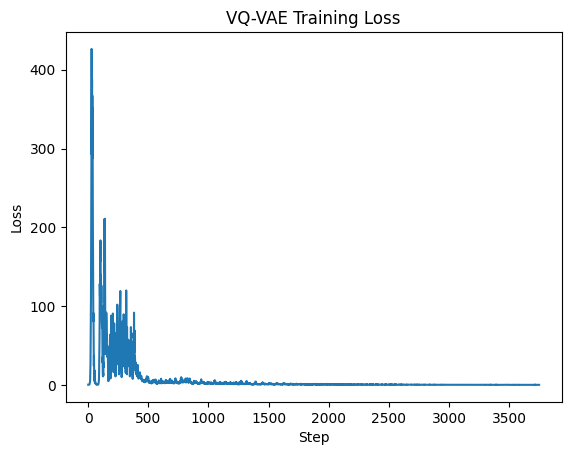

In [34]:
EPOCHS_VQ = 2   # raise to 5+ for better quality
LAMBDA_VQ = 1.0

vq_losses = []

for epoch in range(1, EPOCHS_VQ + 1):
    model_vq.train()
    pbar = tqdm(loader, desc=f"VQ-VAE epoch {epoch}/{EPOCHS_VQ}")

    for x in pbar:
        x = x.to(device)
        x_hat, vq_loss = model_vq(x)

        recon = torch.mean(torch.abs(x_hat - x))
        loss = recon + LAMBDA_VQ * vq_loss

        opt_vq.zero_grad()
        loss.backward()
        opt_vq.step()

        vq_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "recon": f"{recon.item():.4f}", "vq": f"{vq_loss.item():.4f}"})

    ck = f"{CKPT_DIR}/vqvae_epoch_{epoch}.pt"
    torch.save(model_vq.state_dict(), ck)
    print("Saved:", ck)

plt.figure()
plt.plot(vq_losses)
plt.title("VQ-VAE Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

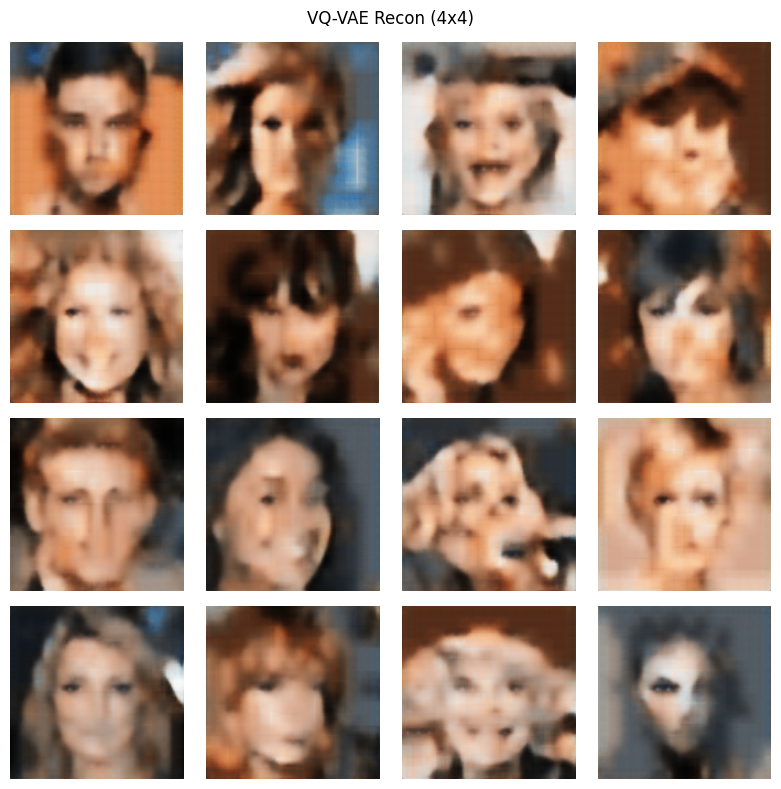

VQ-VAE samples saved to: /content/project_outputs/samples/vqvae
Files: 993


In [36]:
# 4x4 recon grid
model_vq.eval()
x = next(iter(loader))[:16].to(device)
with torch.no_grad():
    x_hat, _ = model_vq(x)

save_grid(x_hat, f"{OUT_VQVAE}/vqvae_recon_grid.png", title="VQ-VAE Recon (4x4)")

# Generate 1000 samples by sampling codebook indices
idx = 0
with torch.no_grad():
    for _ in range(1000 // 16):
        B = 16
        z_shape = (B, 256, 16, 16)

        # sample indices then lookup embeddings
        code_idx = torch.randint(0, model_vq.vq.n_codes, (B*16*16,), device=device)
        z_q = model_vq.vq.codebook(code_idx).view(B, 16, 16, 256).permute(0,3,1,2).contiguous()

        x_gen = model_vq.dec(z_q)
        export_many_pngs("vqvae", x_gen, OUT_VQVAE, idx)
        idx += B

print("VQ-VAE samples saved to:", OUT_VQVAE)
print("Files:", len(os.listdir(OUT_VQVAE)))


In [37]:
T = 200
betas = torch.linspace(1e-4, 2e-2, T, device=device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

@torch.no_grad()
def encode_latents(x):
    z = model_vq.enc(x)   # [B,256,16,16]
    return z

@torch.no_grad()
def decode_latents(z):
    # quantize before decoding (closer to VQ-VAE behavior)
    z_q, _ = model_vq.vq(z)
    return model_vq.dec(z_q)

def q_sample(z0, t, noise):
    a = alphas_bar[t].view(-1,1,1,1)
    return torch.sqrt(a)*z0 + torch.sqrt(1-a)*noise

class SmallUNet(nn.Module):
    def __init__(self, ch=256):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU(),
                                   nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(ch, ch, 4, 2, 1), nn.ReLU(),
                                   nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU())
        self.mid  = nn.Sequential(nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU())
        self.up2  = nn.Sequential(nn.ConvTranspose2d(ch, ch, 4, 2, 1), nn.ReLU(),
                                  nn.Conv2d(ch, ch, 3, 1, 1), nn.ReLU())
        self.out  = nn.Conv2d(ch, ch, 3, 1, 1)
        self.t_embed = nn.Sequential(nn.Linear(1, ch), nn.ReLU(), nn.Linear(ch, ch))

    def forward(self, x, t):
        te = self.t_embed(t.float().view(-1,1) / (T-1)).view(-1, 256, 1, 1)
        d1 = self.down1(x + te)
        d2 = self.down2(d1)
        m  = self.mid(d2)
        u2 = self.up2(m) + d1
        return self.out(u2)

denoiser = SmallUNet().to(device)
opt_ldm = torch.optim.Adam(denoiser.parameters(), lr=2e-4)

print("Latent diffusion denoiser ready")

Latent diffusion denoiser ready


LDM epoch 1/2: 100%|██████████| 1875/1875 [01:52<00:00, 16.66it/s, mse=0.6650]


Saved: /content/project_outputs/checkpoints/ldm_epoch_1.pt


LDM epoch 2/2: 100%|██████████| 1875/1875 [01:54<00:00, 16.45it/s, mse=0.6798]


Saved: /content/project_outputs/checkpoints/ldm_epoch_2.pt


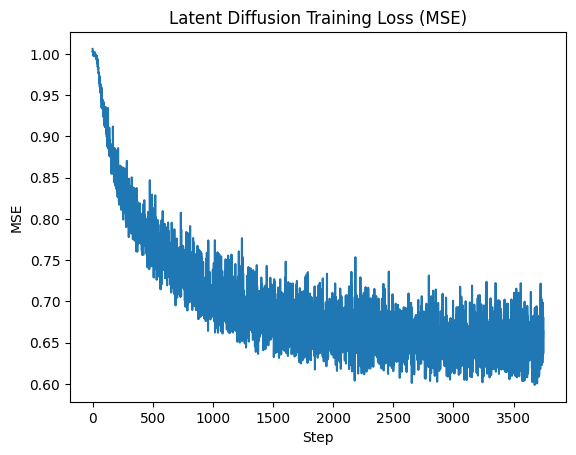

In [38]:
EPOCHS_LDM = 2   # raise to 5+ for better quality
ldm_losses = []

model_vq.eval()  # freeze VQ-VAE during diffusion training
for p in model_vq.parameters():
    p.requires_grad = False

for epoch in range(1, EPOCHS_LDM + 1):
    denoiser.train()
    pbar = tqdm(loader, desc=f"LDM epoch {epoch}/{EPOCHS_LDM}")

    for x in pbar:
        x = x.to(device)
        with torch.no_grad():
            z0 = encode_latents(x)

        B = z0.size(0)
        t = torch.randint(0, T, (B,), device=device)
        noise = torch.randn_like(z0)
        zt = q_sample(z0, t, noise)

        pred = denoiser(zt, t)
        loss = F.mse_loss(pred, noise)

        opt_ldm.zero_grad()
        loss.backward()
        opt_ldm.step()

        ldm_losses.append(loss.item())
        pbar.set_postfix({"mse": f"{loss.item():.4f}"})

    ck = f"{CKPT_DIR}/ldm_epoch_{epoch}.pt"
    torch.save(denoiser.state_dict(), ck)
    print("Saved:", ck)

plt.figure()
plt.plot(ldm_losses)
plt.title("Latent Diffusion Training Loss (MSE)")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.show()

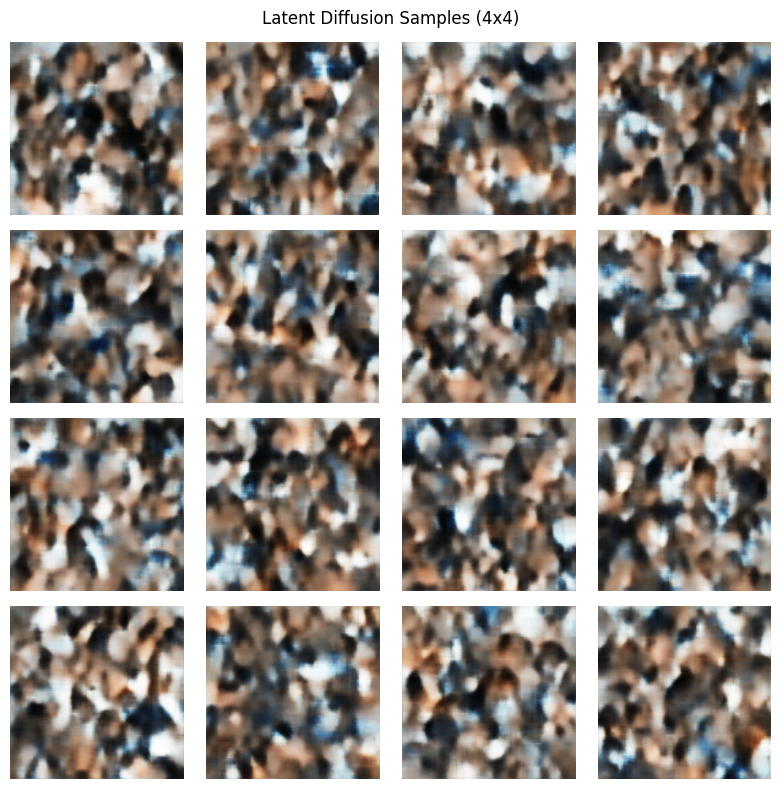

LDM samples saved to: /content/project_outputs/samples/diffusion
Files: 993


In [39]:
!rm -rf "{OUT_LDM}"
!mkdir -p "{OUT_LDM}"

@torch.no_grad()
def p_sample_loop(n=16):
    denoiser.eval()
    z = torch.randn(n, 256, 16, 16, device=device)
    for ti in reversed(range(T)):
        t = torch.full((n,), ti, device=device, dtype=torch.long)
        eps = denoiser(z, t)
        a = alphas[ti]
        ab = alphas_bar[ti]
        z = (1/torch.sqrt(a)) * (z - (1-a)/torch.sqrt(1-ab) * eps)
        if ti > 0:
            z = z + torch.sqrt(betas[ti]) * torch.randn_like(z)
    return z

# 4x4 grid
z = p_sample_loop(16)
x_gen = decode_latents(z)
save_grid(x_gen, f"{OUT_LDM}/ldm_grid.png", title="Latent Diffusion Samples (4x4)")

# export 1000
idx = 0
for _ in range(1000 // 16):
    z = p_sample_loop(16)
    x_gen = decode_latents(z)
    export_many_pngs("ldm", x_gen, OUT_LDM, idx)
    idx += 16

print("LDM samples saved to:", OUT_LDM)
print("Files:", len(os.listdir(OUT_LDM)))


In [41]:
import os, glob, shutil
from PIL import Image

def make_clean_256(src_dir, dst_dir, max_images=1000):
    shutil.rmtree(dst_dir, ignore_errors=True)
    os.makedirs(dst_dir, exist_ok=True)

    exts = ("*.png","*.jpg","*.jpeg","*.PNG","*.JPG","*.JPEG")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(src_dir, e))
    files = sorted(files)

    kept = 0
    skipped = 0

    for f in files:
        try:
            img = Image.open(f).convert("RGB")
            w, h = img.size

            # keep only exact 256x256
            if (w, h) != (256, 256):
                skipped += 1
                continue

            out_path = os.path.join(dst_dir, f"img_{kept:05d}.png")
            img.save(out_path)
            kept += 1

            if kept >= max_images:
                break
        except Exception:
            skipped += 1
            continue

    print(f"Cleaned {src_dir} -> {dst_dir}")
    print("Kept:", kept, "Skipped (wrong size/bad):", skipped)

CLEAN_REAL  = f"{METRICS_DIR}/real_256"
CLEAN_VQVAE = f"{METRICS_DIR}/vqvae_256"
CLEAN_LDM   = f"{METRICS_DIR}/ldm_256"

make_clean_256(REAL_DIR,   CLEAN_REAL,  max_images=1000)
make_clean_256(OUT_VQVAE,  CLEAN_VQVAE, max_images=1000)
make_clean_256(OUT_LDM,    CLEAN_LDM,   max_images=1000)


Cleaned /content/project_outputs/real_1000 -> /content/project_outputs/metrics/real_256
Kept: 1000 Skipped (wrong size/bad): 0
Cleaned /content/project_outputs/samples/vqvae -> /content/project_outputs/metrics/vqvae_256
Kept: 992 Skipped (wrong size/bad): 1
Cleaned /content/project_outputs/samples/diffusion -> /content/project_outputs/metrics/ldm_256
Kept: 992 Skipped (wrong size/bad): 1


In [43]:
from torch_fidelity import calculate_metrics

def fid_kid(real_dir, fake_dir, kid_subset_size=500):
    m = calculate_metrics(
        input1=real_dir,
        input2=fake_dir,
        cuda=torch.cuda.is_available(),
        fid=True,
        kid=True,
        isc=False,
        kid_subset_size=kid_subset_size
    )
    return {
        "FID": float(m["frechet_inception_distance"]),
        "KID": float(m["kernel_inception_distance_mean"])
    }

results = []
results.append({"Model": "VQ-VAE", **fid_kid(CLEAN_REAL, CLEAN_VQVAE, kid_subset_size=500)})
results.append({"Model": "Latent Diffusion", **fid_kid(CLEAN_REAL, CLEAN_LDM, kid_subset_size=500)})

import pandas as pd
df = pd.DataFrame(results)
df_path = f"{METRICS_DIR}/fid_kid_table_clean.csv"
df.to_csv(df_path, index=False)

print(df)
print("Saved:", df_path)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/content/project_outputs/metrics/real_256" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/content/project_outputs/metrics/vqvae_256" with extensions png,jpg,jpeg
Found 992 samples
Processing samples
Frechet Inception Distance: 291.1508649235528
Kernel Inception Distance: 0.30756272077560426 ± 0.0025599246168208074
Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/content/project_outputs/metrics/real_256" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/content/project_outputs/metrics/ldm_256" with extensions png,jpg,jpeg
Found 992 samples
Processing samples
Frechet I

              Model         FID       KID
0            VQ-VAE  291.150865  0.307563
1  Latent Diffusion  429.582427  0.596689
Saved: /content/project_outputs/metrics/fid_kid_table_clean.csv


In [44]:
import os, glob, shutil

def trim_to_n(folder, n):
    files = sorted(glob.glob(os.path.join(folder, "*.png")) +
                   glob.glob(os.path.join(folder, "*.jpg")) +
                   glob.glob(os.path.join(folder, "*.jpeg")))
    for f in files[n:]:
        os.remove(f)
    print(folder, "now has", len(sorted(glob.glob(os.path.join(folder, "*.png")))), "pngs (approx)")

# trim real to 992 to match fake
trim_to_n(CLEAN_REAL, 992)

/content/project_outputs/metrics/real_256 now has 992 pngs (approx)


In [45]:
m = calculate_metrics(
    input1=CLEAN_REAL,
    input2=CLEAN_VQVAE,
    cuda=torch.cuda.is_available(),
    fid=True,
    kid=False,
    isc=False
)
print("FID:", float(m["frechet_inception_distance"]))

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/project_outputs/metrics/real_256" with extensions png,jpg,jpeg
Found 992 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "/content/project_outputs/metrics/vqvae_256" with extensions png,jpg,jpeg
Found 992 samples
Processing samples


FID: 291.0925273909686


Frechet Inception Distance: 291.0925273909686
